In [13]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import copy

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
theBest = [0, 0]

for i in range(10):

    # train the model
    accuracy = np.random.rand()

    # see if this is better than any previous runs
    if accuracy > theBest[0]:
        theBest = [accuracy, i]

print(f'Highest "accuracy" was {100*theBest[0]:.2f}% in run {theBest[1] + 1}')

Highest "accuracy" was 93.83% in run 6


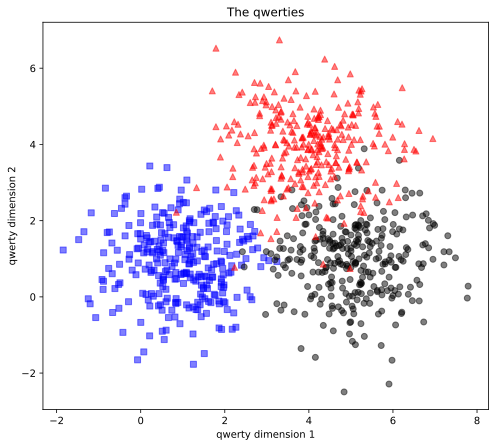

In [5]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 4 ]

# generate data
a = [ A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [ B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [ C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]
# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1)),np.full((nPerClust,1),2)))

#convert to a pytorch tensor
data_np = np.hstack((a,b,c)).T



# convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize = (8,7))
# color = 'bkr'
# for i in range(len(data)):
#     plt.plot([0, data[i, 0]], [0,data[i, 1]], color = color[labels[i]], alpha = .2)
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs', alpha = .5)
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', alpha = .5)
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels == 2)[0], 1], 'r^', alpha = .5)

plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [9]:
partitions = [3*nPerClust - 400, 200, 200]

# split the data
train_data, devtest_data, train_labels, devtest_labels = train_test_split(data, labels, train_size = partitions[0])


# now split the devtest data
dev_data, test_data, dev_labels, test_labels = train_test_split(devtest_data, devtest_labels, train_size = partitions[1])

In [10]:
train_data = TensorDataset(train_data, train_labels)
dev_data = TensorDataset(dev_data, dev_labels)
test_data = TensorDataset(test_data, test_labels)

# finally translate into dataloader objects
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
dev_loader = DataLoader(dev_data, batch_size = len(dev_data), shuffle = True)
test_loader = DataLoader(test_data, batch_size = len(test_data), shuffle = True)


In [33]:
# create a class for the model
def createTheQwertyNet():

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,3)

    # forward pass
    def forward(self,x):

      x = x[:,:2]
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )

      return self.output(x)

  # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [40]:
# a function that trains the model

def function2trainTheModel():

  theBestModel = {'Accuracy':0,'net':None}
  # number of epochs
  numepochs = 1000

  # create a new model
  net,lossfun,optimizer = createTheQwertyNet()

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  devAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )


    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    devAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

    if devAcc[-1] > theBestModel['Accuracy']:

        theBestModel['Accuracy'] = devAcc[-1].item()
        theBestModel['net'] = copy.deepcopy(net.state_dict())
  # end epochs

  # function output
  return trainAcc,devAcc,losses,theBestModel

In [41]:
trainAcc, devAcc, losses, theBestModel = function2trainTheModel()

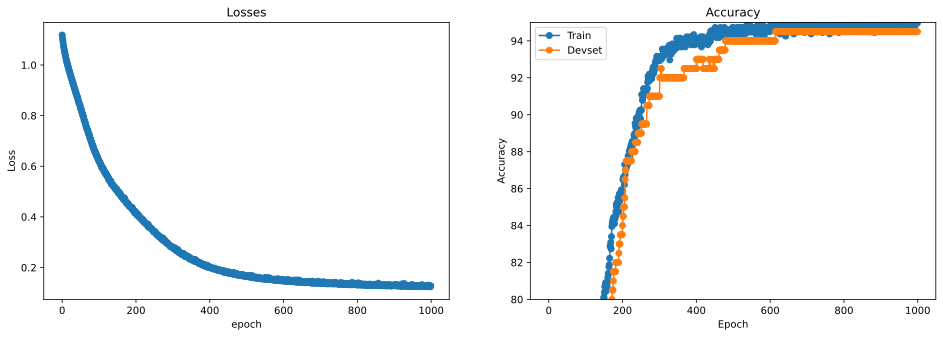

In [52]:
fig, ax = plt.subplots(1,2, figsize = (16,5))

ax[0].plot(losses.detach(), 'o-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc, 'o-', label = 'Train')
ax[1].plot(devAcc, 'o-', label = 'Devset')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].set_ylim([80,95])
# ax[1].set_xlim([80,105])
ax[1].legend()
plt.show()

In [43]:
theBestModel

{'Accuracy': 94.5,
 'net': OrderedDict([('input.weight',
               tensor([[ 0.5684, -0.0672],
                       [ 0.5315,  0.0224],
                       [ 0.1583,  0.3651],
                       [-0.0982,  0.7477],
                       [ 0.5729,  0.4146],
                       [-0.4818,  0.4490],
                       [ 0.3653, -0.1762],
                       [ 0.7937,  0.1976],
                       [-0.1323,  0.7271],
                       [-0.6623,  0.6095],
                       [ 0.2196,  0.3151],
                       [ 0.6086, -0.3575],
                       [-0.5141, -0.6303],
                       [ 0.1199,  0.2121],
                       [-0.6855,  0.3385],
                       [ 0.7356, -0.5976],
                       [ 0.0739, -0.5398],
                       [-0.6294,  0.2098],
                       [-0.4738, -0.5718],
                       [-0.1538,  0.1908],
                       [-0.2380,  0.5989],
                       [ 0.3540, -0.6420

In [45]:
X, y = next(iter(test_loader))

In [46]:
best_net = createTheQwertyNet()[0]
best_net.load_state_dict(theBestModel['net'])

<All keys matched successfully>

In [47]:
X, y = next(iter(test_loader))
yHat = best_net(X)

bestAcc = 100*torch.mean((torch.argmax(yHat, axis = 1) == y).float())
bestAcc

tensor(93.5000)

[]

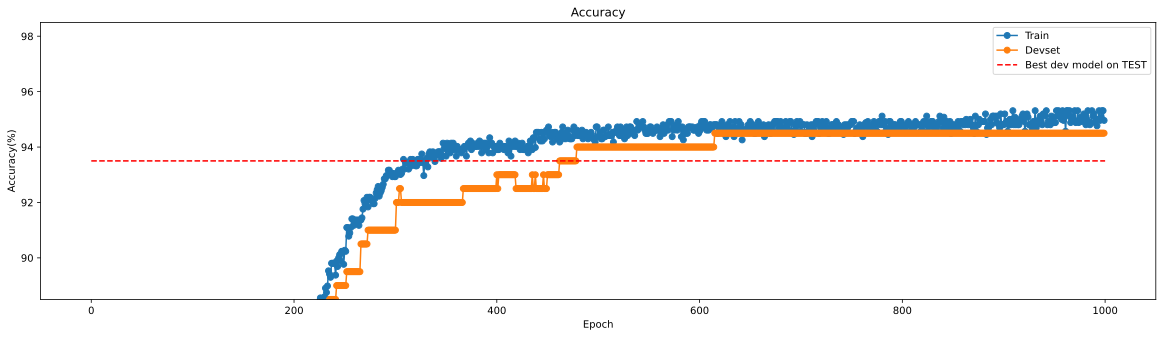

In [50]:
fig = plt.figure(figsize = (20, 5))

plt.plot(trainAcc, 'o-', label = 'Train')
plt.plot(devAcc, 'o-', label = 'Devset')
plt.plot([0, len(devAcc)],[bestAcc,bestAcc], 'r--', label = 'Best dev model on TEST')
plt.ylabel('Accuracy(%)')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.ylim([bestAcc - 5, bestAcc + 5])
plt.legend()
plt.plot()
